# Trabajo práctico 4: Regularización aplicada a la EPH
## Integrantes: Catalina Banfi, Matías Lima, Santiago López

In [1]:
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  # Para matriz de correlaciones
import statsmodels.api as sm   
import seaborn as sns

from sklearn import datasets
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, roc_curve, RocCurveDisplay, plot_roc_curve, average_precision_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from scipy.special import expit

Lo primero que hago es crear un botón que permita esconder todas las celdas que sean código y mostrar todo lo demás si se lo desea. La solución no es original, sino que se obtuvo de una provista por el usuario de Stack Overflow Eric Shepherd en el siguiente link: https://stackoverflow.com/a/53136940

In [2]:
import ipywidgets as widgets
from IPython.display import display, HTML

javascript_functions = {False: "hide()", True: "show()"}
button_descriptions  = {False: "Show code", True: "Hide code"}


def toggle_code(state):

    """
    Toggles the JavaScript show()/hide() function on the div.input element.
    """

    output_string = "<script>$(\"div.input\").{}</script>"
    output_args   = (javascript_functions[state],)
    output        = output_string.format(*output_args)

    display(HTML(output))


def button_action(value):

    """
    Calls the toggle_code function and updates the button description.
    """

    state = value.new

    toggle_code(state)

    value.owner.description = button_descriptions[state]


state = False
toggle_code(state)

button = widgets.ToggleButton(state, description = button_descriptions[state])
button.observe(button_action, "value")

display(button)

ToggleButton(value=False, description='Show code')

También se suma el siguiente código para ocultar las warnings, entendiendo que las mismas son útiles pero molestas en el caso de una presentación cuando ya se entendió el motivo de las mismas. Por este motivo, también se deja comentada una línea que permite limitar la cantidad de advertencias por acción a 1. 

In [3]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

# Parte I: Análisis de la base de hogares y cálculo de pobreza

### 1. Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2022 (la base de hogares se llama usu_hogar_T122.xls). Importen los datos de la encuesta de hogar y al igual que en el TP1 conserven sólo las observaciones que corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o del Gran Buenos Aires.

In [4]:
base_hogar = pd.read_excel("usu_hogar_T122.xlsx")
#base_hogar = pd.read_csv("usu_hogar_T122.csv", low_memory=False)

base_hogar_bs = base_hogar[(base_hogar['AGLOMERADO'] == 32) | (base_hogar['AGLOMERADO'] == 33)]

### 2. Unan la tabla de la encuesta individual con la de la encuesta de hogar. Asegúrense de estar usando las variables CODUSU y NRO_HOGAR.

In [5]:
base_individual = pd.read_excel("usu_individual_T122.xlsx")
#base_individual = pd.read_csv("usu_individual_T122.csv", low_memory=False)

base_individual_bs = base_individual[(base_individual['AGLOMERADO'] == 32) | (base_individual['AGLOMERADO'] == 33)]

In [7]:
base_merge = base_individual_bs.merge(base_hogar_bs, left_on=['CODUSU', 'NRO_HOGAR'], right_on=['CODUSU', 'NRO_HOGAR'], how='outer', suffixes=('', '_y'))

base_merge.drop(base_merge.filter(regex='_y$').columns, axis=1, inplace=True)

base_merge

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNOSUPHKKPQCDEIJAH00780151,2022,1,1,1,1,1,S,33,1741,...,2,3,0,3,1,2,3,0,0,0
1,TQRMNOSUPHKKPQCDEIJAH00780151,2022,1,1,2,1,1,S,33,1741,...,2,3,0,3,1,2,3,0,0,0
2,TQRMNOSUPHKKPQCDEIJAH00780151,2022,1,1,3,1,1,S,33,1741,...,2,3,0,3,1,2,3,0,0,0
3,TQRMNOPQQHKMRLCDEIJAH00780169,2022,1,1,1,1,1,S,33,456,...,2,1,0,1,1,0,98,0,0,0
4,TQRMNOSXRHJMTRCDEIJAH00693084,2022,1,1,1,1,1,S,33,1199,...,2,2,0,2,1,3,98,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6701,TQRMNOTTSHKNLSCDEIIAD00780102,2022,1,1,2,1,1,S,32,2839,...,2,2,0,2,1,0,98,0,0,0
6702,TQRMNOPRPHMNMLCDEIIAD00701192,2022,1,1,1,1,1,S,32,2131,...,2,2,0,2,2,0,98,0,0,0
6703,TQRMNOPRPHMNMLCDEIIAD00701192,2022,1,1,2,1,1,S,32,2131,...,2,2,0,2,2,0,98,0,0,0
6704,TQRMNOSRWHKMLUCDEIIAD00780103,2022,1,1,1,1,1,S,32,1513,...,2,2,0,2,1,0,2,0,0,0


### 3. Limpien la base de datos tomando criterios que hagan sentido, tanto para el tratamiento de los valores faltantes, de los outliers, como así también decidan qué variables categóricas y strings usarán y transfórmenlas de forma que haga sentido para los ejercicios siguientes. Justifiquen sus decisiones.

Con el primer código lo que queremos es ver qué columnas tienen una gran cantidad de valores faltantes, para darnos una idea de cuál sería una cantidad justa para eliminar de la base. En base a eso, decidimos que columnas con más de un 50% de valores faltantes sean descartadas. Luego, lo que usamos es una función de numpy, .isna, que nos permite setear con condiciones qué columnas se van a eliminar.

In [8]:
print("Amount of missing values in - ")
for column in base_merge.columns:
    percentage_missing = np.mean(base_merge[column].isna())
    print(f'{column} : {round(percentage_missing*100)}%')

Amount of missing values in - 
CODUSU : 0%
ANO4 : 0%
TRIMESTRE : 0%
NRO_HOGAR : 0%
COMPONENTE : 0%
H15 : 0%
REGION : 0%
MAS_500 : 0%
AGLOMERADO : 0%
PONDERA : 0%
CH03 : 0%
CH04 : 0%
CH05 : 0%
CH06 : 0%
CH07 : 0%
CH08 : 0%
CH09 : 0%
CH10 : 0%
CH11 : 0%
CH12 : 0%
CH13 : 0%
CH14 : 52%
CH15 : 0%
CH15_COD : 82%
CH16 : 0%
CH16_COD : 98%
NIVEL_ED : 0%
ESTADO : 0%
CAT_OCUP : 0%
CAT_INAC : 0%
IMPUTA : 99%
PP02C1 : 0%
PP02C2 : 0%
PP02C3 : 0%
PP02C4 : 0%
PP02C5 : 0%
PP02C6 : 0%
PP02C7 : 0%
PP02C8 : 0%
PP02E : 0%
PP02H : 0%
PP02I : 0%
PP03C : 56%
PP03D : 56%
PP3E_TOT : 56%
PP3F_TOT : 56%
PP03G : 56%
PP03H : 56%
PP03I : 56%
PP03J : 56%
INTENSI : 56%
PP04A : 56%
PP04B_COD : 56%
PP04B1 : 56%
PP04B2 : 56%
PP04B3_MES : 56%
PP04B3_ANO : 56%
PP04B3_DIA : 56%
PP04C : 56%
PP04C99 : 56%
PP04D_COD : 56%
PP04G : 56%
PP05B2_MES : 56%
PP05B2_ANO : 56%
PP05B2_DIA : 56%
PP05C_1 : 56%
PP05C_2 : 56%
PP05C_3 : 56%
PP05E : 56%
PP05F : 56%
PP05H : 56%
PP06A : 56%
PP06C : 56%
PP06D : 56%
PP06E : 56%
PP06H : 56%
PP07A :

In [9]:
na_percentage = base_merge.isna().sum()/base_merge.shape[0]*100
col_to_drop = na_percentage[na_percentage>50].keys() # Eliminamos las columnas con más de 50% de missing values.
base_merge2 = base_merge.drop(col_to_drop, axis=1)

In [10]:
base_merge3 = base_merge2[base_merge2.select_dtypes(include=[np.number]).ge(0).all(1)].reset_index(drop=True)
base_merge3

# Por fuera de los paquetes, eliminamos observaciones con datos NS/NC en la variable para cantidad de habitaciones 
base_merge3 = base_merge3[(base_merge3['IV2'] < 99)]

Una vez hecha la limpieza, nos concentramos en transformar variables categóricas que creemos que son importantes (no observamos ningún string como importante por eso no hacemos nada con respecto a eso). Seleccionamos las variables que mencionamos como comentario a continuación porque creemos que son importantes para el análisis de la pobreza. Estas son: el tipo de vivienda, el material de los pisos, de dónde consigue agua el hogar, la fuente de agua, si tiene baño, dónde está el baño, si la vivienda está ubicada en la proximidad de un basural, si la vivienda está ubicada en una villa de emergencia, el régimen de tenencia, el combustible utilizado para cocinar, el origen de los ingresos de los habitantes de la vivienda (salarios por trabajo, jubilaciones o pensiones, o subsidios o ayuda social), el decil de ingreso en el que se encuentra el hogar, si el individuo sabe leer y escribir, si asiste a un establecimiento educativo, qué tipo de establecimiento es, y, por último, cuál es el nivel educativo que cursa o el más alto que alcanzó.

In [10]:
# Categorica: IV1, IV3, IV6, IV7, IV8, IV9, IV12_1, IV12_3, II7, II8, V1, V2, V5, DECCFR, CH09, CH10, CH11, CH12

In [11]:
for col in ['IV1', 'IV3', 'IV6', 'IV7', 'IV8', 'IV9', 'IV12_1', 'IV12_3', 'II7', 'II8', 'V1', 'V2', 'V5', 'DECCFR', 'CH09', 'CH10', 'CH11', 'CH12']:
    base_merge3[col] = base_merge3[col].astype('category')

In [13]:
base_merge3

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,V19_B,IX_TOT,IX_MEN10,IX_MAYEQ10,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNOSUPHKKPQCDEIJAH00780151,2022,1,1,2,1,1,S,33,1741,...,2,3,0,3,1,2,3,0,0,0
1,TQRMNOPQQHKMRLCDEIJAH00780169,2022,1,1,1,1,1,S,33,456,...,2,1,0,1,1,0,98,0,0,0
2,TQRMNOSXRHJMTRCDEIJAH00693084,2022,1,1,1,1,1,S,33,1199,...,2,2,0,2,1,3,98,0,0,0
3,TQRMNOSXRHJMTRCDEIJAH00693084,2022,1,1,3,1,1,S,33,1199,...,2,2,0,2,1,3,98,0,0,0
4,TQRMNOSXXHKOKMCDEIJAH00780170,2022,1,1,1,1,1,S,33,2812,...,2,1,0,1,1,0,98,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5291,TQRMNOTTRHJMLMCDEIIAD00718251,2022,1,1,1,1,1,S,32,1125,...,2,1,0,1,96,0,98,0,0,0
5292,TQRMNOPRPHMNMLCDEIIAD00701192,2022,1,1,1,1,1,S,32,2131,...,2,2,0,2,2,0,98,0,0,0
5293,TQRMNOPRPHMNMLCDEIIAD00701192,2022,1,1,2,1,1,S,32,2131,...,2,2,0,2,2,0,98,0,0,0
5294,TQRMNOSRWHKMLUCDEIIAD00780103,2022,1,1,1,1,1,S,32,1513,...,2,2,0,2,1,0,2,0,0,0


### 4. Construyan variables (mínimo 2) que no estén en la base pero que sean relevantes a la hora de predecir individuos bajo la línea de pobreza (ej. proporción de mujeres (o niños) en el hogar, ¿su cónyuge trabaja?)

La primera variable que construimos muestra la proporción de menores de 10 años que hay en el hogar (Prop_Men10). Consideramos que es una variable importante a la hora de predecir si un hogar es pobre ya que, como sabemos, la pobreza infantil es una realidad que afecta a nuestro pais. La segunda variable que creamos toma en consideración variables descriptivas de los materiales con los cuales están hechos los hogares, y nos informa con un 1 cuando un hogar está construido con materiales de baja calidad (casa_mala). Por éltimo, creamos una tercera variable binaria que indica con un 1 cuando el hogar está sobrepoblado (potencial_hacinamiento).

In [14]:
# Primero creamos la variable proporcion de menores de 10 en el hogar

base_merge3['Prop_Men10'] = base_merge3.apply(lambda row: row.IX_MEN10 / row.IX_TOT, axis=1)



In [15]:
# Casa de materiales malos

def f(x):
    '''
    esta funcion lo que hace es buscar casas que cumplan la condicion de estar hecha de materiales malos (ladrillo suelto
    o tierra) con el objetivo de crear una nueva columna, llamada casa_mala
    '''
    
    if x['IV1'] == 1 and x['IV3'] == 3:
        return 1
    else:
        return 0

base_merge3['casa_mala'] = base_merge3.apply(f, axis=1).astype('category') 

In [16]:
def g(x):
    '''
    esta funcion crea una condicion que devuelve un 1 si hay mas miembros totales del hogar que ambientes
    '''
    
    if x['IX_TOT'] > x['II1']:
        return 1
    else:
        return 0

base_merge3['potencial_hacinamiento'] = base_merge3.apply(g, axis=1).astype('category')   
    

### 5. Sean creativos y presenten un gráfico (que no sea de barras) para describir la interacción o correlación entre dos o más variables.

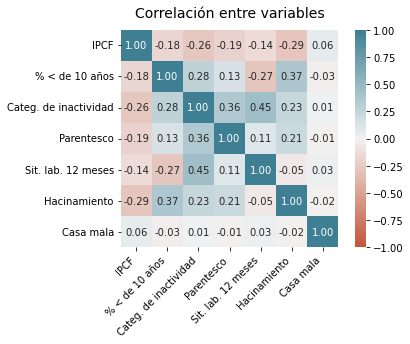

In [24]:
# Creamos una base auxiliar para calcular la correlacion entre distintas variables
base_corr = base_merge3[['IPCF', 'Prop_Men10', 'CAT_INAC', 'CH03', 'PP02I','potencial_hacinamiento', 'casa_mala']]

plt.title('Correlación entre variables', y=1.03, size=14)

# Definimos las labels para el heatmap. 

x_axis_labels = ['IPCF', '% < de 10 años', 'Categ. de inactividad', 'Parentesco', 'Sit. lab. 12 meses', 'Hacinamiento', 'Casa mala']

ax = sns.heatmap(
    base_corr.astype(float).corr(), 
    vmin=-1, vmax=1, center=0, fmt='.2f',
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    xticklabels=x_axis_labels,
    yticklabels=x_axis_labels
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### 6. Construyan la columna adulto_equiv y la columna ad_equiv_hogar y luego dividan la base en dos dataframes donde: uno conserve las personas que reportaron ITF (llamada respondieron) y la otra conserve las personas que no reportaron ITF (llamada norespondieron). Además, agreguen a la base respondieron una columna llamada ingreso_necesario que sea el producto de la canasta básica por ad_equiv_hogar.

In [25]:
# Importamos y limpiamos las filas vacias de la tabla de equivalencias
tabla_equivalencias = pd.read_excel("tabla_adulto_equiv.xlsx", skiprows=[0, 1, 2, 4, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [26]:
# Cambiamos una fila de la tabla de equivalencias para que sea igual a nuestros datos
tabla_equivalencias.at[1, 'Edad'] = '1 años'

In [27]:
# Creamos una funcion lambda donde, segun el rango de edad, genera otra columna con el mismo formato que el de tabla de equivalencias 
base_merge3['Edad'] = base_merge3['CH06'].apply(lambda x: '61 a 75 años' if x >= 61 and x <= 75 else ('46 a 60 años' if x >= 46 and x <= 60 else 
                                                                                                          ('30 a 45 años' if x >= 30 and x <= 45 else 
                                                                                                           ('18 a 29 años' if x >= 18 and x <= 29 else
                                                                                                           ('más de 75 años' if x > 75 else ('Menor de 1 año' if x < 1 else
                                                                                                                                             str(x)+ ' años'))))))

# Hacemos el mismo proceso anterior pero ahora para una tabla de genero
base_merge3['Genero'] = base_merge3['CH04'].apply(lambda x: 'Varones' if x <= 1 else 'Mujeres') 

In [28]:
# Partimos la base en dos (mujeres y hombres) para agilizar el proximo loop
base_mujeres = base_merge3[(base_merge3['CH04'] == 2)]
base_varones = base_merge3[(base_merge3['CH04'] == 1)]

In [29]:
# Para la base de mujeres, corremos un loop que busca por cada valor de la columna Edad, en la base del INDEC, y lo matchea con los valores de la columna Mujeres, de la tabla de equivalencias.

lista = []
for i in range(0, len(base_mujeres)):
    for x in range(0, len(tabla_equivalencias)):
        if base_mujeres.iloc[i]['Edad'] == tabla_equivalencias.iloc[x]['Edad']:
             lista.append(tabla_equivalencias.iloc[x]['Mujeres'])
base_mujeres['adulto_equiv'] = lista

In [30]:
# Repetimos el mismo proceso para la base de Hombres
lista_2 = []
for i in range(0, len(base_varones)):
    for x in range(0, len(tabla_equivalencias)):
        if base_varones.iloc[i]['Edad'] == tabla_equivalencias.iloc[x]['Edad']:
             lista_2.append(tabla_equivalencias.iloc[x]['Varones'])
base_varones['adulto_equiv'] = lista_2   

In [32]:
# Unimos ambas bases 
base_merge3 = base_mujeres.append(base_varones)

#Finamente, creamos la columna de equivalencias nutricionales por hogar
data = base_merge3.groupby(['CODUSU', 'NRO_HOGAR']).sum()[['adulto_equiv']]
data = data.rename(columns={'adulto_equiv':'ad_equiv_hogar'})

In [33]:
base_merge4 = base_merge3.merge(data, left_on=['CODUSU', 'NRO_HOGAR'], right_on=['CODUSU', 'NRO_HOGAR'], how='outer')

In [34]:
# Creamos las bases pedidas en la consigna
respondieron =  base_merge4[(base_merge4['ITF'] > 0)]
norespondieron = base_merge4[(base_merge4['ITF'] == 0)]

In [35]:
respondieron['ingreso_necesario'] = respondieron['ad_equiv_hogar'].apply(lambda x: x*27197.64)

### 7. Agreguen a respondieron una columna llamada pobre que tome valor 1 si el ITF es menor al ingreso_necesario que necesita esa familia, y 0 en caso contrario.

In [36]:
def pobre(respondieron):
    '''
    esta función busca si los ingresos totales familiares son menores que los ingresos necesarios
    para que un hogar no sea pobre, así como lo contrario, y nos devuelve un 1 si se cumple que 
    los ingresos totales son menores que los necesarios, y un 0 si son mayores o iguales. 
    '''
    if respondieron['ITF'] < respondieron['ingreso_necesario']:
        return 1
    elif respondieron['ITF'] >= respondieron['ingreso_necesario']:
        return 0

In [37]:
#ahora creamos una columna nueva que surge de aplicar la función que definimos a nuestra base de datos. 
respondieron['pobre'] = respondieron.apply(pobre, axis=1)

### 8. Para calcular la tasa de hogares bajo la linea de pobreza utilicen una sola observación por hogar y sumen el ponderador PONDIH que permite expandir la muestra de la EPH al total de la población que representa. ¿Cuál es la tasa de hogares bajo la línea de pobreza para el Gran Buenos Aires? ¿Lograron que se asemeje al% que reporta el INDEC?

In [38]:
#Creamos un objeto donde por hogar se suman las ponderaciones y se promedia el valor de "pobre". Para que el hogar sea considerado pobre, todos sus integrantes deben serlo, por lo que este cálculo nos permite luego seleccionar solo aquellos hogares donde el promedio de la variable "pobre" sea 1 (lo que da cuenta de que todos sus integrantes tenían este valor).

pondih = respondieron.groupby(['CODUSU', 'NRO_HOGAR']).agg({'PONDIH' : 'sum', "pobre" : "mean"})
    
(pondih.loc[pondih['pobre'] == 1, "PONDIH"].sum()) / (pondih["PONDIH"].sum())

print("El",round(pondih.loc[pondih['pobre'] == 1, "PONDIH"].sum() / (pondih["PONDIH"].sum())*100,2),"% de hogares es pobre.")

El 33.73 % de hogares es pobre.


Como puede verse arriba, la tasa de pobreza que identificamos mediante los ingresos familiares declarados es del 33,73%, mientras que el informe elaborado por el INDEC para el mismo período identifica al 28,2% de los hogares del GBA como pobres. Esta diferencia es congruente con una posible hipótesis de subreporte de ingresos en la EPH, lo que nos haría estimar una mayor cantidad de pobres de la real si tomamos solo la variable ITF.

# Parte II: Construcción de funciones

### 1. Escriban una función, llamada evalua_metodo, que reciba como argumentos un modelo y los datos de entrenamiento y prueba (X_train, y_train, X_test, y_test). La función debe ajustar el modelo con los datos de entrenamiento y calcular las métricas que considere necesarias para esta problemática (de mínima debe reportar falsos positivos, falsos negativos, verdaderos positivos, verdaderos negativos, AUC, accuracy y precision de cada método). El output de la función debe ser una colección con las métricas evaluadas.

In [39]:
def evalua_metodo(method, x_train, y_train, x_test, y_test):
    '''
    Esta función recibe como inputs un método ya definido y un dataset ya dividido entre X e Y para entrenamiento y test, 
    ajustando los datos al método brindado para generar los output consistentes en determinadas medidas de precisión: 
    accuracy, matriz de confusión y sus componentes (verdadero negativo, falso positivo, falso negativo, verdadero positivo), área bajo la curva ROC, ECM y el Average Precision Score (AP). 
    '''
    
    metodofit = method.fit(x_train, y_train)
    y_pred = metodofit.predict(x_test)
    y_pred = np.where(y_pred > 0.5, 1, y_pred)
    y_pred = np.where(y_pred <= 0.5, 0, y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    matriz_confusion = confusion_matrix(y_test, y_pred)
    tn, fp , fn, tp = confusion_matrix(y_test, y_pred).ravel() 
    ecm = mean_squared_error(y_test, y_pred)
    ap = average_precision_score(y_test, y_pred)

    return (accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap,metodofit)

### 2. Escriban una función, llamada cross_validation, que realice validación cruzada con k iteraciones (k-fold CV), llamando a la función del inciso anterior en cada una, pero para las k distintas particiones. La función debe recibir como argumentos el modelo, el valor de k y un dataset (es decir, sólo X e y). Pueden ayudarse con la función KFold para generar las particiones necesarias.

In [40]:
def cross_validation(model, k, x, y):
    '''
    Esta función toma como inputs un método ya configurado, el K para saber la cantidad de iteraciones a realizarse en 
    k-fold CV y los dataset con las variables (x,y). 
    Lo que hace entonces es parte al dataset en K particiones de entrenamiento y test, aplicándole a cada una la función
    evalua_metodo. 
    El output está formado por diferentes métricas de precisión para cada una de las particiones analizadas:
    es una colección del K, accuracy, ECM, AP y el método analizado.
    '''
    kf = KFold(n_splits=k, shuffle=True, random_state=10)
    resultados = pd.DataFrame(columns=["K", "accuracy", "ecm", "ap", "auc", "método"]) 
    for i, (train_index, test_index) in enumerate(kf.split(x)):   
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        sc = StandardScaler()
        X_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
        X_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)
        
        accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, metodofit = evalua_metodo(model, X_train_transformed, y_train, X_test_transformed, y_test)
        K = i+1
        resultados = resultados.append({"K":i+1, "accuracy":accuracy, "ecm":ecm, "ap":ap, "auc": auc, "método":metodofit}, ignore_index=True)
    #return resultados
    return (K, accuracy, auc, ecm, ap, model)

### 3. Escriban una función, llamada evalua_config que reciba una lista de configuraciones de hiperparámetros (los distintos valores a probar como hiperparámetros podrían codificarse en diccionarios de Python) y utilizando la función cross_validation obtenga el error promedio para cada configuración. Finalmente, la función debe devolver la configuración que genere menor error. Asegúrense de que esta función sirva para cualquier hiperparámetro que quieran elegir por cross validation para cualquier modelo.

In [44]:
def evalua_config(metodo, x, y,k, lambdas=None, penalty1=None, neigh=None, kern=None):
    '''
    Esta función tiene como objetivo iterar entre los distintos valores de los hiperparámetros indicados para obtener los valores que minimicen el ECM de la regresión. 
    Entre los parámetros obligatorios, el primer input es el método, los dos siguientes son los dataset con las variables (x,y) y finaliza con el rango de K para iterar. 
    Luego continuamos con parámetros opcionales según el método que se busque optimizar: penalty1 corresponde a las penalidades de Logit, lambdas a los distintos valores del hiperparámetro de los métodos Logit y SVC para optimizar, neigh para indicar los distintos posibles valores del número de vecinos en KNN y kern al tipo de Kernel utilizado en el método SVC.
    El output de la función es un DataFrame con los distintos valores obtenidos y sus especificaciones según el método testeado, el valor del ECM que se corresponde con el valor del hiperparámetro que minimiza esta medida y el valor de dicho hiperparámetro. 
    '''
    
    ecms =  pd.DataFrame(columns=["alp", "neigh", "ecm", "K","penalty"])
    
    if metodo == ("logit"):
        for i in lambdas:
                C_alpha = 1/i
                model = LogisticRegression(penalty = penalty1, C = C_alpha, max_iter=1000, solver="saga")
                k, accuracy, auc, ecm, ap, metodo = cross_validation(model,k,x,y)
                ecms = ecms.append({"alp":i, "ecm":ecm, "K": k,"penalty":penalty1}, ignore_index=True)
    
        ecms_avg = ecms.groupby('alp').agg({'ecm':'mean'}).reset_index()
        min_ecm = np.Inf
        param_ecm = None
        for index, row in ecms_avg.iterrows():
            if row['ecm'] < min_ecm:
                min_ecm = row['ecm']
                param_ecm = row['alp']
    elif metodo == "knn":
        for n in neigh:
                model = KNeighborsClassifier(n_neighbors=n)
                k, accuracy, auc, ecm, ap, metodo = cross_validation(model,k,x,y)
                ecms = ecms.append({"neigh":n, "ecm":ecm, "K": k}, ignore_index=True)
        ecms_avg = ecms.groupby('neigh').agg({'ecm':'mean'}).reset_index()
        min_ecm = np.Inf
        param_ecm = None
        for index, row in ecms_avg.iterrows():
            if row['ecm'] < min_ecm:
                min_ecm = row['ecm']
                param_ecm = row['neigh'].astype('int')
    elif metodo == "SVC":
        for i in lambdas:
                C_alpha = 1/i
                model = SVC(kernel= kern)
                k, accuracy, auc, ecm, ap, metodo = cross_validation(model,k,x,y)
                ecms = ecms.append({"alp":i, "ecm":ecm, "K": k,"penalty":penalty1}, ignore_index=True)
    
        ecms_avg = ecms.groupby('alp').agg({'ecm':'mean'}).reset_index()
        min_ecm = np.Inf
        param_ecm = None
        for index, row in ecms_avg.iterrows():
            if row['ecm'] < min_ecm:
                min_ecm = row['ecm']
                param_ecm = row['alp']
    return (ecms,min_ecm,param_ecm)

### 4. Escriban una función, llamada evalua_multiples_metodos que les permita implementar los métodos que se enumeran a continuación. Esta función debe utilizar su función evalua_config para optimizar los parámetros que ustedes decidan (de mínima deben optimizar el K -cantidad de vecinos- para el modelo de KNN). Finalmente, el output de la función debe ser una tabla donde las columnas sean las métricas que hayan evaluado (las que hayan incluido en la función evalua_metodo) y las filas sean los modelos (con su configuración de hiperparámetros asociada) que hayan corrido: Regresión logística, Análisis de discriminante lineal, KNN, Árbol de decisión, Support vector machines (SVM), Bagging, Random Forests, Boosting.

In [45]:
def evalua_multiples_metodos(metodos, x, y, parametros):
    '''
    El objetivo de esta función es poder generar una tabla con métricas descriptivas de la performance de diferentes métodos, 
    en base a los hiperparámetros determinados y/o la configuración brindada por el usuario al llamar la función. 
    De esta manera, el primer input es un diccionario con los métodos a correr: KNN para el método KNN, 
    LDA para el método de análisis de discriminante lineal y Logit para el método de regresión logística. 
    Tree es el valor indicado para árbol de decisión, Bagg para Bagging, Rand_For para Random Forest, Grad_Boost para Gradient Boosting.
    Finalmente, SVC corresponde a Support Vector Classification.
    
    En segundo lugar, deben indicarse los dataset con las variables x e y para considerar en los métodos.
    Finalmente, también debe indicarse un diccionario con la configuración de los parámetros requeridos por los métodos a analizarse. 
    
    Parámetros: 
    Para optimizar el lambda de la regularización, debe indicarse en el diccionario "parametros" los diferentes 
    valores de lambda a ser iterados, buscando obtenerse el que minimice el ECM (tanto para Logit como para SVC). Lo mismo se aplica a la cantidad de vecinos en KNN, mediante el campo "neighbors".
    
    "k" en el input "parametros" representa la cantidad de particiones a probarse en el proceso de Cross Validation. Lo mismo sucede con el campo "components" para los componentes de LDA.
    Por otro lado, si se va a correr un método Logit, es necesario indicar el campo "penalty" de "parameters", 
    con una lista para las distintas penalidades a analizarse, siendo los valores l1 y l2 los correspondientes a LASSO y Ridge,
    respectivamente.
    Para CART es necesario indicar la máxima profundidad del árbol a través del campo "max_depth" en el input "parameters". 
    Para Bagging, los campos requeridos son n_est y max_samp, para la cantidad de métodos a correr y el número de observaciones para cada árbol, respectivamente. 
    Para Random Forest se agrega "max_feat" para indicar la cantidad de predictores a utilizar en cada paso. 
    Para Boosting se usan los parámetros n_est y max_depth definidos previamente.
    Finalmente, para SVC, además de los lambdas mencionados previamente, se utiliza el parámetro kernel para el tipo de kernel utilizado en el algoritmo.
    
    
    El output de la función, por su parte, es una tabla que indica el método analizado, 
    los valores de sus parámetros y las medidas de Accuracy, ECM, AP, AUC y la Matriz de Confusión.
        
    '''
    tabla =  pd.DataFrame(columns=["Metodo", "Accuracy", "ECM", "AP", "AUC", "Verdadero 0", "Falso 1", "Falso 0", "Verdadero 1", "Neighbors", "Components", "Alp_best", "Max_depth", "n_est", "Max_samp", "Max_feat", "Kernel"])
    ecms_p = pd.DataFrame(columns=["alp", "ecm", "K","penalty"])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
    sc = StandardScaler()
    X_train_transformed = pd.DataFrame(sc.fit_transform(x_train),index=x_train.index, columns=x_train.columns)
    X_test_transformed = pd.DataFrame(sc.transform(x_test),index=x_test.index, columns=x_test.columns)
    for metodo in metodos:
        if metodo == "KNN":
            ecms, min_ecm, param_ecm = evalua_config("knn",x,y, parametros["k"], neigh=parametros["neighbors"])
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, metodofit=evalua_metodo(KNeighborsClassifier(n_neighbors=param_ecm),X_train_transformed,y_train,X_test_transformed,y_test)
            tabla = tabla.append({"Metodo":metodo, "Neighbors": param_ecm,"Accuracy":accuracy, "AUC":auc, "ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
        elif metodo == "LDA":
            components= parametros["components"]
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, metodofit = evalua_metodo(LinearDiscriminantAnalysis(n_components=components),X_train_transformed,y_train,X_test_transformed,y_test)
            tabla = tabla.append({"Metodo":metodo, "Components": components,"Accuracy":accuracy, "AUC":auc,"ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
        elif metodo == "Logit":
            for p in parametros["penalty"]:
                ecms, min_ecm, param_ecm = evalua_config("logit",x,y, parametros["k"], lambdas=parametros["lambda"],penalty1=p)
                accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, metodofit = evalua_metodo(LogisticRegression(penalty = p, C = 1/param_ecm, max_iter=1000, solver="saga"),X_train_transformed,y_train,X_test_transformed,y_test)
                tabla = tabla.append({"Metodo":metodo + ' (' + p + ')',"Alp_best": param_ecm,"Accuracy":accuracy, "AUC":auc, "ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
                ecms_p = ecms_p.append(ecms)
        elif metodo == "Tree":
            maxdepth = parametros["max_depth"]
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, metodofit = evalua_metodo(DecisionTreeClassifier(max_depth = maxdepth, random_state=10), X_train_transformed, y_train, X_test_transformed, y_test)
            tabla = tabla.append({"Metodo":metodo, "Max_depth":maxdepth, "Accuracy":accuracy, "AUC":auc,"ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
        elif metodo == "Bagg":
            n_est = parametros["n_est"]
            max_samp = parametros["max_samp"]
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, metodofit = evalua_metodo(BaggingRegressor(n_estimators=n_est, max_samples=max_samp, random_state=10), X_train_transformed, y_train, X_test_transformed, y_test)
            tabla = tabla.append({"Metodo":metodo, "n_est":n_est, "Max_samp": max_samp, "Accuracy":accuracy, "AUC":auc,"ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
        elif metodo == "Rand_For":
            n_est = parametros["n_est"]
            max_samp = parametros["max_samp"]
            max_feat = parametros["max_feat"]
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, metodofit = evalua_metodo(RandomForestRegressor(n_estimators=n_est, max_samples=max_samp, max_features=max_feat, random_state=10), X_train_transformed, y_train, X_test_transformed, y_test)
            tabla = tabla.append({"Metodo":metodo, "n_est":n_est, "Max_samp": max_samp, "Max_feat":max_feat, "Accuracy":accuracy, "AUC":auc,"ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
        elif metodo == "Grad_Boost":
            n_est = parametros["n_est"]
            maxdepth = parametros["max_depth"] 
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, metodofit = evalua_metodo(GradientBoostingRegressor(n_estimators=n_est, max_depth=maxdepth, random_state=10), X_train_transformed, y_train, X_test_transformed, y_test)
            tabla = tabla.append({"Metodo":metodo, "n_est":n_est, "Max_depth":maxdepth, "Accuracy":accuracy, "AUC":auc,"ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp}, ignore_index=True)
        elif metodo == "SVC":
            ecms, min_ecm, param_ecm = evalua_config("SVC",x,y, parametros["k"], lambdas=parametros["lambda"],kern = parametros["kernel"])
            accuracy, matriz_confusion, tn, fp, fn, tp, auc, ecm, ap, metodofit = evalua_metodo(SVC(kernel= parametros["kernel"], C = 1/param_ecm), X_train_transformed, y_train, X_test_transformed, y_test)
            tabla = tabla.append({"Metodo":metodo, "Alp_best": param_ecm, "Accuracy":accuracy, "AUC":auc,"ECM":ecm, "AP":ap, "Verdadero 0": tn, "Falso 1": fp, "Falso 0": fn, "Verdadero 1": tp, "Kernel": parametros["kernel"]}, ignore_index=True)
    tabla = tabla.fillna('')
    return [tabla,ecms_p]

# Parte III: Clasificación y Regularización

### 1. Eliminen de ambas bases (respondieron, norespondieron) todas las variables relacionadas a ingresos (en el archivo codigos_eph.pdf ver las categorías: ingresos de la ocupación principal de los asalariados, ingresos de la ocupación principal, ingresos de otras ocupaciones, ingreso total individual, ingresos no laborales, ingreso total familiar, ingreso per cápita familiar). Elimine también las columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario. Establezcan a pobre como su variable dependiente (vector y). El resto de las variables serán las variables independientes (matriz X).

In [46]:
# Eliminamos las variables relacionadas a ingresos y las columnas de las bases respondieron/no respondieron
respondieron = respondieron.drop(['P21', 'DECOCUR',  'RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'TOT_P12'], axis=1) # ingresos de la ocupación principal y de otras ocupaciones
respondieron = respondieron.drop(['P47T', 'DECINDR',  'RDECINDR', 'GDECINDR', 'ADECINDR'], axis=1) # ingresos total individual
respondieron = respondieron.drop(['V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI'], axis=1) # ingresos no laborales
respondieron = respondieron.drop(['ITF', 'DECIFR', 'RDECIFR', 'GDECIFR',  'ADECIFR'], axis=1) # ingreso total familiar
respondieron = respondieron.drop(['IPCF', 'DECCFR', 'RDECCFR', 'GDECCFR',  'ADECCFR'], axis=1) # ingreso per capita familiar
respondieron = respondieron.drop(['adulto_equiv', 'ad_equiv_hogar', 'ingreso_necesario'], axis=1) # columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario

norespondieron = norespondieron.drop(['P21', 'DECOCUR',  'RDECOCUR', 'GDECOCUR', 'ADECOCUR', 'TOT_P12'], axis=1) # ingresos de la ocupación principal y de otras ocupaciones
norespondieron = norespondieron.drop(['P47T', 'DECINDR',  'RDECINDR', 'GDECINDR',  'ADECINDR'], axis=1) # ingresos total individual
norespondieron = norespondieron.drop(['V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI'], axis=1) # ingresos no laborales
norespondieron = norespondieron.drop(['ITF', 'DECIFR', 'RDECIFR', 'GDECIFR',  'ADECIFR'], axis=1) # ingreso total familiar
norespondieron = norespondieron.drop(['IPCF', 'DECCFR',  'RDECCFR', 'GDECCFR',  'ADECCFR'], axis=1) # ingreso per capita familiar
norespondieron = norespondieron.drop(['adulto_equiv', 'ad_equiv_hogar'], axis=1) # columnas adulto_equiv, ad_equiv_hogar e ingreso_necesario

### 2. Corran la función evalua_multiples_metodos con la base respondieron. Asegurense de estar utilizando su función de evalua_config para optimizar algunos hiperparámetros (de mínima el K en el modelo KNN).

In [47]:
y = respondieron['pobre']
# Nos quedamos con las variables de la base que nos sirven para hacer la regresion
x = respondieron[['IV1', 'IV3', 'IV6', 'IV7', 'IV8', 'IV9', 'IV12_1', 'IV12_3', 'II7', 'II8', 'V1', 'V2', 'V5', 'CH09', 'CH10', 'CH11', 'CH12', 'CH06','casa_mala', 'Prop_Men10', 'potencial_hacinamiento']]
x = sm.add_constant(x) # Agregamos la columna de unos.
x=x.astype('int')
y=y.astype('int')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=101)  

In [48]:
metodos = ["LDA", "Logit", "KNN", "Tree","Bagg","Rand_For", "Grad_Boost", "SVC"]
parametros = {"k": 3, "neighbors":range(2,20), "components":1, "penalty": ["l1","l2"], "lambda": list(10**np.linspace(6,-2,50)*0.5), "max_depth":7, "n_est":40, "max_samp":200, "max_feat":19, "kernel":"rbf"} #Penalty de Lasso, la l2 es Ridge. 

eval_metodos = evalua_multiples_metodos(metodos,x,y,parametros)
                                                 
eval_metodos[0]

,Metodo,Accuracy,ECM,AP,AUC,Verdadero 0,Falso 1,Falso 0,Verdadero 1,Neighbors,Components,Alp_best,Max_depth,n_est,Max_samp,Max_feat,Kernel
0,LDA,0.786382,0.213618,0.528108,0.707773,472,40,120,117,,1,,,,,,
1,Logit (l1),0.789052,0.210948,0.533869,0.714259,470,42,116,121,,,0.032756,,,,,
2,Logit (l2),0.789052,0.210948,0.533869,0.714259,470,42,116,121,,,0.147353,,,,,
3,KNN,0.797063,0.202937,0.553611,0.741648,457,55,97,140,9,,,,,,,
4,Tree,0.809079,0.190921,0.572369,0.727774,486,26,117,120,,,,7,,,,
5,Bagg,0.805073,0.194927,0.565560,0.740708,469,43,103,134,,,,,40,200,,
6,Rand_For,0.811749,0.188251,0.578771,0.751257,469,43,98,139,,,,,40,200,19,
7,Grad_Boost,0.838451,0.161549,0.632850,0.776454,484,28,93,144,,,,7,40,,,
8,SVC,0.805073,0.194927,0.567976,0.750907,460,52,94,143,,,0.005,,,,,rbf


### 3. ¿Cuál de todos los métodos evaluados predice mejor? ¿Con qué hiperparámetros? Justifiquen utilizando las medidas de precisión que conoce.

Basandonos en la tabla presentada en el inciso anterior, el método que minimiza el ECM y tiene la mejor precisión es Gradient Boosting (con un máximo de siete particiones y 40 estimaciones). En comparación con el resto de los métodos, esta variable de Boosting también cuenta con el área más grande debajo de la curva ROC. 

Si la idea es identificar hogares pobres para planificar políticas públicas, el objetivo pasaría a ser el de identificar la mayor cantidad posible de verdaderos positivos, ya que esto daría un mayor alcance dentro de la población objetivo. Teniendo en cuenta esto, Gradient Boosting sigue siendo el mejor método para predecir, ya que cuenta con 144 verdaderos positivos (seguido de cerca por SVC, con 143 y un alfa optimizado mediante KFold CV en un valor de 0.005).  

### 4. ¿Lograron mejorar sus predicciones respecto al TP3?

En el TP anterior, con el metodo LDA predecíamos 112 verdaderos positivos. Como mencionamos en el inciso 3, la cantidad de verdaderos postivos predichos por Boosting es de 144. Por lo tanto hay una notable diferencia en la capacidad predictiva respecto del trabajo previamente entregado. Incluso, si comparamos el método que predecía con un menor ECM en el TP3, también podemos ver una mejora. Para el trabajo previo, Logit (con λ = 0.00001) predecía con un ECM igual a 0.217623. En este caso, Boosting arroja un ECM igual a 0.161549.

Es importante aclarar que, además de agregar las variables nuevas que creímos relevantes y de incorporar metodos a nuestra función de evaluación, realizamos ajustes en las funciones respecto a las entregadas en el código anterior. Por esta razón, la mejora en todos los métodos bajo evaluación respnde a varios factores, pero Gradient Boosting con las especificaciones mencionadas supera en todas las métricas al resto, tanto en minimización del error, precisión y clasificación.

### 5. Con el método que seleccionaron, predigan qué personas son pobres dentro de la base norespondieron. ¿Qué proporción de los hogares son pobres en esa submuestra?

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

grad_boost_final = GradientBoostingRegressor(n_estimators=40, max_depth=7, random_state=10)
grad_boost_final_fit = grad_boost_final.fit(x_train, y_train)

y_pred = grad_boost_final_fit.predict(x_test)
y_pred = np.where(y_pred > 0.5, 1, y_pred)
y_pred = np.where(y_pred <= 0.5, 0, y_pred)

count = np.count_nonzero(y_pred == 1)

print("En base al método de Gradient Boosting, la cantidad predicha de hogares pobres para la submuestra es de", count)

proporcion = np.count_nonzero(y_pred == 1)/(len(y_pred))
proporcion = proporcion*100
print("La proporción de hogares pobres en la submuestra es del %.2f" % proporcion,"%.")

En base al método de Gradient Boosting, la cantidad predicha de hogares pobres para la submuestra es de 172
La proporción de hogares pobres en la submuestra es del 22.96 %.


Tal como muestra el *print* de la celda superior, estimar la proporción de hogares pobres en nuestra submuestra mediante Gradient Boosting nos permite identificar que un 22.96% de los hogares son pobres (correspondiéndose esto con un total de 172). Esto es una mejora contra el TP3, donde nuestra predicción mediante el método LDA era del 20.29%, ya que ahora nos acercamos más al valor publicado por INDEC para este período (28.2%), como indicábamos en el ejercicio 8 de la parte I.